In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
from collections import Counter
import hashlib
import pandas as pd
# import numpy as np
from dotenv import load_dotenv
import logging
# from typing import Union, List, Tuple
from pathlib import Path

from datetime import datetime
from tqdm.notebook import tqdm

from emv.db.dao import DataAccessObject
from emv.db_settings import DATABASE_URL
from emv.db.queries import get_library_id_from_name
from emv.api.models import Media
from emv.db.queries import create_media
from emv.storage.storage import get_storage_client
from emv.api.models import Media
from emv.io.media import trim_binary, get_frame_rate

from IPython.display import Video

logging.basicConfig(level=logging.INFO)

load_dotenv()
DataAccessObject().connect(DATABASE_URL)

In [5]:
# Setup before we can create media objects
OUTDIR = 'data'
archive_name =  "ioc"
bucket_name =  archive_name
library_id =  get_library_id_from_name(archive_name)
library_id

3

In [6]:
metadata = '../data/metadata.hdf5'
with pd.HDFStore(metadata) as store:
    keys = store.keys()
    df = store.get(keys[0])  

In [7]:
def find_mp4_files(root_folder):
    mp4_files = []

    for foldername, _, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.endswith('.mp4'):
                mp4_files.append(os.path.join(foldername, filename))

    return mp4_files

In [8]:
mp4_files = find_mp4_files("/media/data/ioc/videos/")
print(f"Found {len(mp4_files)} mp4 files")
print(f"Found {df.guid.nunique()} unique guids")

Found 31304 mp4 files
Found 21712 unique guids


In [9]:
file_map = {}
for mp4 in mp4_files:
    file_map[mp4.split('/')[-1].split('.')[0]] = mp4

guids = set(df['guid'].tolist())
len(guids)

21712

In [10]:
# check if guids are in the file map
counter = 0
for key in file_map.keys():
    if key not in guids:
        counter += 1
print(f"Missing {counter} files")

# check the other way around
counter = 0
for guid in guids:
    if guid not in file_map.keys():
        counter += 1
print(f"Missing {counter} guids")

Missing 13527 files
Missing 18486 guids


In [11]:
df.head()

,guid,seq_id,date,duration,start,end,description,event,extra,duration_sec,sport,category,raw_round,details,round
0,MDA30000800,SEQ30097620,1996-07-30,0 days 00:04:57,19:55:05:00,20:00:02:00,START OF TRANSMISSION EVENT: DIVING WOMEN'S 3M...,Diving/Women's 3m Springboard[W]/Preliminary,{},297.0,Diving,Women's 3m Springboard[W],Preliminary,,Preliminary
1,MDA30000800,SEQ30097621,1996-07-30,0 days 00:00:07,20:00:02:00,20:00:09:00,START: DIVE 1,Diving/Women's 3m Springboard[W]/Preliminary,{},7.0,Diving,Women's 3m Springboard[W],Preliminary,,Preliminary
2,MDA30000800,SEQ30097622,1996-07-30,0 days 00:01:42,20:00:09:00,20:01:51:00,DIVE: JPN MOTOBUCHI SCORE: 51.12,Diving/Women's 3m Springboard[W]/Preliminary,{},102.0,Diving,Women's 3m Springboard[W],Preliminary,,Preliminary
3,MDA30000800,SEQ30097623,1996-07-30,0 days 00:01:04,20:01:51:00,20:02:55:00,DIVE: CAN PELLETIER SCORE: 61.38,Diving/Women's 3m Springboard[W]/Preliminary,{},64.0,Diving,Women's 3m Springboard[W],Preliminary,,Preliminary
4,MDA30000800,SEQ30097624,1996-07-30,0 days 00:00:58,20:02:55:00,20:03:53:00,DIVE: USA MOSES SCORE: 51.03,Diving/Women's 3m Springboard[W]/Preliminary,{},58.0,Diving,Women's 3m Springboard[W],Preliminary,,Preliminary


In [12]:
# How many files do we have where the metadata matches the file id?
len(set(df.guid.tolist()) & set(file_map.keys()))
print(f"Found {len(set(df.guid.tolist()) & set(file_map.keys()))} matches")

Found 3226 matches


In [13]:
# keep only the sequences that we have the video for
df_seq = df[df.guid.isin(list(set(df.guid.tolist()) & set(file_map.keys())))]

In [16]:
# Check which olympic games the sequences are from
df_seq.date.apply(lambda x: x.year).value_counts()

date
2021    674342
1996        37
2012         3
1998         1
Name: count, dtype: int64

In [ ]:
df_seq[df_seq.date.apply(lambda x: x.year == 1996)]

In [12]:
guid_counter = Counter()

for guid in df.guid.unique().tolist():
    guid_counter[guid[:4]] += 1

print(f"Most common guids in DataFrame: {guid_counter.most_common(10)}")

file_counter = Counter()

for guid in file_map.keys():
    file_counter[guid[:4]] += 1

print(f"Most common guids for the MP4 Files: {file_counter.most_common(10)}")

Most common guids in DataFrame: [('MDA3', 11791), ('MDA4', 9921)]
Most common guids for the MP4 Files: [('MDA4', 16724), ('MDA3', 18), ('MDA2', 11)]


<Axes: >

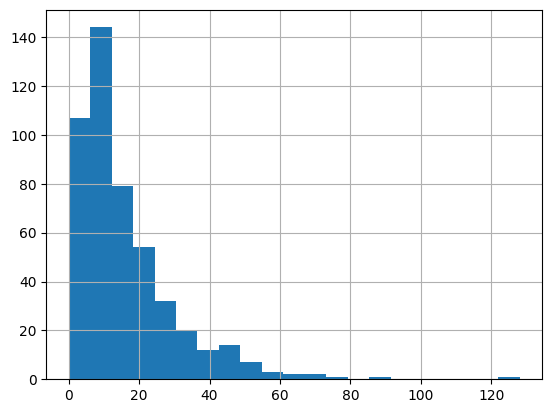

In [22]:
df_norm.duration_sec.hist(bins=21)

In [ ]:
total_duration = 0
for i, row in df_norm.iterrows():
    print(i, row.seq_id, row.duration_sec, row.description, row.duration, total_duration, datetime.strptime(row.start, '%H:%M:%S:%f') - datetime.strptime(df_norm.iloc[0].start, '%H:%M:%S:%f'), row.start)
    total_duration += row.end_ts - row.start_ts